## Bregman block average co-clustering algorithm.

The implementation of Bregman block average co-clustering algorithm (Banerjee et al., 2007) is inpired in the [single node impementation](https://github.com/fnyanez/bbac), [Copyright (c) 2016 Felipe Yanez](https://github.com/fnyanez/bbac/blob/master/LICENSE.md).

### Support functions

Translation is done using [R documentation about Matrix Algebra](http://www.statmethods.net/advstats/matrix.html).

#### R
```
calculate_average <- function(Left, Z, Right, W, epsilon) {
  if (is.null(W)) {
      W <- array(1, dim(Z))
  } else {
      Z <- W * Z
  }
  numerator <- t(Left) %*% Z %*% Right + mean(Z) * epsilon
  denominator <- t(Left) %*% W %*% Right + epsilon
  return(numerator/denominator)
}
```

In [1]:
calculate_average <- function(Left, matrixDF, Right, W, epsilon) {
    if (is.null(W)) {
        #A 2D array, i.e., a Matrix for which each cell is set with the value 1
        W <- array(1, dim(matrixDF))
    } else {
        # Element-wise multiplication
        matrixDF <- W * matrixDF
    }
    # t(Left) is Matrix transpose
    # %*% means matrix mutiplication
    # mean(matrix) gives a single value which is the mean of all values in the matrix
        # y=mean(x,'r') (or, equivalently, y=mean(x,1)) is the rowwise mean.
        # y=mean(x,'c') (or, equivalently, y=mean(x,2)) is the columnwise mean. 
    # Right + means(matrix) is a element-wise addition
    numerator <- t(Left) %*% matrixDF %*% Right + mean(matrixDF) * epsilon
    
    denominator <- t(Left) %*% W %*% Right + epsilon
    return(numerator/denominator)
}

#### R

```
coCavg <- function(dist, row_col, R, Z, C, W, epsilon) {
  CoCavg <- calculate_average(R, Z, C, W, epsilon)
  if (row_col=="row") {
    return(list(Zrowc = array(dist, dim(Z)), Zrowv = CoCavg %*% t(C)))
  } else if (row_col=="col") {
    return(list(Zcolc = array(dist, dim(Z)), Zcolv = R %*% CoCavg))
  }
}
```

In [2]:
coCavg <- function(dist, row_col, R, matrixDF, C, W, epsilon) {
    CoCavg <- calculate_average(R, matrixDF, C, W, epsilon)
    if (row_col=="row") {
        #Creates a list and names the elements. Such names can then be used to access them in an easy way.
        return(list(Zrowc = array(dist, dim(matrixDF)), Zrowv = CoCavg %*% t(C)))
    } else if (row_col=="col") {
        return(list(Zcolc = array(dist, dim(matrixDF)), Zcolv = R %*% CoCavg))
    }
}

#### R

```
similarity_measure <- function(dist, Z, X, Y, W, epsilon) {
  if (is.null(W)) W <- array(1, dim(Z))
  if (dist==0) {
    euc <- function(i) rowSums(W * (Z - X - rep(Y[i,], each = dim(Z)[1]))^2)
    return(sapply(1:dim(Y)[1], euc))
  } else if (dist==1) {
    return((W * X) %*% t(Y + epsilon) - (W * Z) %*% log(t(Y + epsilon)))
  }
}
```

In [3]:
similarity_measure <- function(dist, matrixDF, X, Y, W, epsilon) {
    if (is.null(W))
        W <- array(1, dim(matrixDF))
    if (dist==0) {
        # rowSums sum values of Raster objects.
        # rep vector several times, but with each we repeat the values, in this case has many as the matrixDF rows
        #> rep(1:4, 2)
        #  [1] 1 2 3 4 1 2 3 4
        # > rep(1:4, each = 2)       # not the same.
        #  [1] 1 1 2 2 3 3 4 4
        euc <- function(i) rowSums(W * (matrixDF - X - rep(Y[i,], each = dim(matrixDF)[1]))^2)
            return(sapply(1:dim(Y)[1], euc))
    } else if (dist==1) {
        # log(t(Y + epsilon)): sum epsilon to all elements of Y, transpose it and do the log to each element of the transpose matrix  
        return((W * X) %*% t(Y + epsilon) - (W * Z) %*% log(t(Y + epsilon)))
    }
}

#### R

```
assign_cluster <- function(dist, Z, X, Y, W, epsilon) {
  D <- similarity_measure(dist, Z, X, Y, W, epsilon)
  id <- sapply(1:dim(D)[1], function(i) sort(D[i,], index.return = TRUE)$ix[1])
  res <- sapply(1:dim(D)[1], function(i) sort(D[i,])[1]^(2-dist))
  return(list(Cluster = diag(dim(Y)[1])[id,], Error = sum(res)))
}
```

In [4]:
assign_cluster <- function(dist, matrixDF, X, Y, W, epsilon) {
    D <- similarity_measure(dist, matrixDF, X, Y, W, epsilon)
    # apply(Matrix, <row or col>, func) -> <row or col> 1 is row-wise, 2 is col-wise
    # sapply is like lapply (it applies a function to each element of a list and the result is also a list) consumes data as a vector. 
    # dim(D)[1] gives number of rows.
    # sort a each row increasing order and return index, we get the indice of the highest value 
    id <- sapply(1:dim(D)[1], function(i) sort(D[i,], index.return = TRUE)$ix[1])
    res <- sapply(1:dim(D)[1], function(i) sort(D[i,])[1]^(2-dist))
    
    # Create an identity matrix, diag(dim(Y)[1]), which has num_rows and num_cols = dim(Y)[1], i.e., number of rows of Y, and set diagonal to 1.
    # dim(Y)[1])[id,] -> Give me the row from the identity matrix which has indice "id"
    return(list(Cluster = diag(dim(Y)[1])[id,], Error = sum(res)))
}

### BBAC
```
Z - m x n data matrix, 
W - m x n measure matrix, 
k - num row clusters,
l - num col clusters
```

In [5]:
bbac <- function(Z, k, l, W = NULL, distance = "euclidean", errobj = 1e-6, niters = 100, nruns = 5, epsilon = 1e-8) {
  
  error <- Inf
  error_now <- Inf
  dist <- pmatch(tolower(distance), c("euclidean","divergence")) - 1
  
  for (r in 1:nruns) {
    
    # Initialization of R and C
      
    #Create an identity matrix
      # Get row which is a random sample (betwewn numRowC and num of rows) with replacement
    R <- diag(k)[base::sample(k, dim(Z)[1], replace = TRUE),]
    C <- diag(l)[base::sample(l, dim(Z)[2], replace = TRUE),]
    
    for (s in 1:niters) {
      
      # Row estimation
      rs <- coCavg(dist, "row", R, Z, C, W, epsilon)
      ra <- assign_cluster(dist, Z, rs$Zrowc, rs$Zrowv, W, epsilon)
      R  <- ra$Cluster
      
      # Column estimation
      cs <- coCavg(dist, "col", R, Z, C, W, epsilon)
      ca <- assign_cluster(dist, t(Z), t(cs$Zcolc), t(cs$Zcolv), W, epsilon)
      C  <- ca$Cluster
      
      # 
      if (abs(ca$Error - error_now) < errobj) {
        status <- paste("converged in",s,"iterations")
        return(list(R = R, C = C, status = status))
      }
      
      # Update objective value
      error_now <- ca$Error
      
    }
    
    # Keep pair with min error
    if (error_now < error) {
      R_star <- R
      C_star <- C
      error <- error_now
    }
    
  }
  
  status <- paste("reached maximum of", niters, "iterations")
  return(list(R = R_star, C = C_star, status = status))
  
}

### Load Data

The data will be loaded from a matrix create in Scala and saved as Parquet file.

#### Simulated matrix

In [6]:
set.seed(1)
Z <- matrix(rep(1:4, 25), 10, 10)

#### GeoTiffs

In [7]:
library(raster)

Loading required package: sp


#### Load Mask

In [8]:
#mask <- raster('/data/local/home/pheno/data/usa_state_masks/california.tif', band=1)
mask <- raster('/data/local/home/pheno/data/usa_state_masks/connecticut.tif', band=1)
#mask <- raster('/data/local/home/pheno/data/usa_state_masks/rhodeIsland.tif', band=1)

In [9]:
rMask <- as.vector(as.matrix(mask))
#mask_index <- which(!is.na(rMask))

#### Load GeoTiffs

In [10]:
r1980 <- raster('/data/local/home/pheno/data/spring-index/light/BloomFinal/1980.tif', band=4)
r1981 <- raster('/data/local/home/pheno/data/spring-index/light/BloomFinal/1981.tif', band=4)
r1982 <- raster('/data/local/home/pheno/data/spring-index/light/BloomFinal/1982.tif', band=4)
r1983 <- raster('/data/local/home/pheno/data/spring-index/light/BloomFinal/1983.tif', band=4)

In [11]:
r1980

class       : RasterLayer 
band        : 4  (of  4  bands)
dimensions  : 3892, 7808, 30388736  (nrow, ncol, ncell)
resolution  : 0.008983153, 0.008983153  (x, y)
extent      : -126.3031, -56.16267, 14.2922, 49.25463  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
data source : /data/local/home/pheno/data/spring-index/light/BloomFinal/1980.tif 
names       : X1980 


#### Apply mask

In [12]:
r1980M <- mask(r1980, mask)
r1981M <- mask(r1981, mask)
r1982M <- mask(r1982, mask)
r1983M <- mask(r1983, mask)

#### To Matrix

In [13]:
m1980 <- as.matrix(r1980M)
m1981 <- as.matrix(r1981M)
m1982 <- as.matrix(r1982M)
m1983 <- as.matrix(r1983M)

#### To Vector

To Vector concatenates column by column. If you need to do row by row, you need to transpose it.

In [14]:
v1980 <- as.vector(m1980)
v1981 <- as.vector(m1981)
v1982 <- as.vector(m1982)
v1983 <- as.vector(m1983)

#### Create Input Matrix

In [30]:
Zindex <- which(!is.na(v1980))
Z <- cbind( v1980[!is.na(v1980)], v1981[!is.na(v1981)], v1982[!is.na(v1982)], v1983[!is.na(v1983)])
dim(Z)

[1] 16999     4

### Run 

In [16]:
# Run co-clustering algorithm
K <- 200
L <- 3
bbac_res <- bbac(Z, k = K, l = L, distance = "e")

In [17]:
R <- bbac_res$R
C <- bbac_res$C
bbac_res$status

[1] "converged in 34 iterations"

### Clean results
Remove the groups which contains zero elements and for each cell get the row-group ID.

#### R

In [18]:
#dim(R)

#We go to remove of row-groups with 0 rows assigned
RT <- t(R)
RTRowSums <- rowSums(RT)
RTClean <- RT[which(RTRowSums > 0),]
row_clus_num <- dim(RTClean)[1]

#Collect the row-group indice for each row
R <- t(RTClean)
rIndices <- which(R > 0, arr.in=TRUE)
rFrame <- as.data.frame(rIndices)
colnames(rFrame) <- c("cell", "row_clus")

#### C

In [19]:
#dim(C)

#We go to remove of col-groups with 0 rows assigned
CT <- t(C)
CTRowSums <- rowSums(CT)
CTClean <- CT[which(CTRowSums > 0),]
col_clus_num <- dim(CTClean)[1]


#Collect the col-group indice for each col
C <- t(CTClean)
cIndices <- which(C > 0, arr.in=TRUE)
cFrame <- as.data.frame(cIndices)
colnames(cFrame) <- c("year","col_clus")

### Create co_cluster matrix for Kmeans

In [20]:
all_years <- seq(1,dim(Z)[2], 1)
all_cells <- seq(1,dim(Z)[1], 1)

co_clusters <- matrix(, row_clus_num, col_clus_num)

for (col_clus_ID in (1:col_clus_num)){
    years <- cFrame[cFrame$col_clus == col_clus_ID,]$year
    for (row_clus_ID in (1:row_clus_num)) {
        cells <- rFrame[rFrame$row_clus == row_clus_ID,]$cell

        #mask_clust[row_clus_ID, col_clus_ID] 
        other_years <- !(all_years %in% (years))
        other_cells <- !(all_cells %in% (cells))
        co_clusters[row_clus_ID, col_clus_ID] <- round(mean(Z[other_cells, other_years]))
    }
}
#co_clusters

### Build a matrix for each col_cluster with average spring-index

In [22]:
col_clus_matrices <- matrix(, dim(Z)[1], col_clus_num)

for (col_clus_ID in (1:col_clus_num)){
    for (row_clus_ID in (1:row_clus_num)) {      
        #Set all the cells in row_clus_ID to the average value or co_cluster_ID
        cells_to_set <- rFrame[rFrame$row_clus == row_clus_ID,]$cell
        
        #Set co_cluster average
        col_clus_matrices[cells_to_set, col_clus_ID] = co_clusters[row_clus_ID, col_clus_ID]
    }
}

### Build Rasters

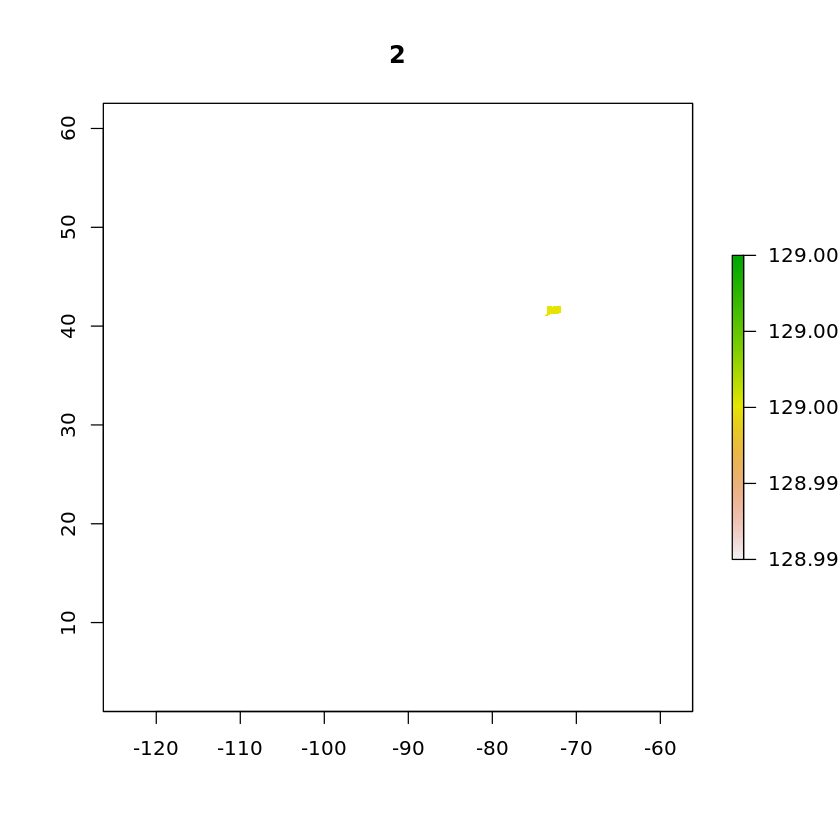

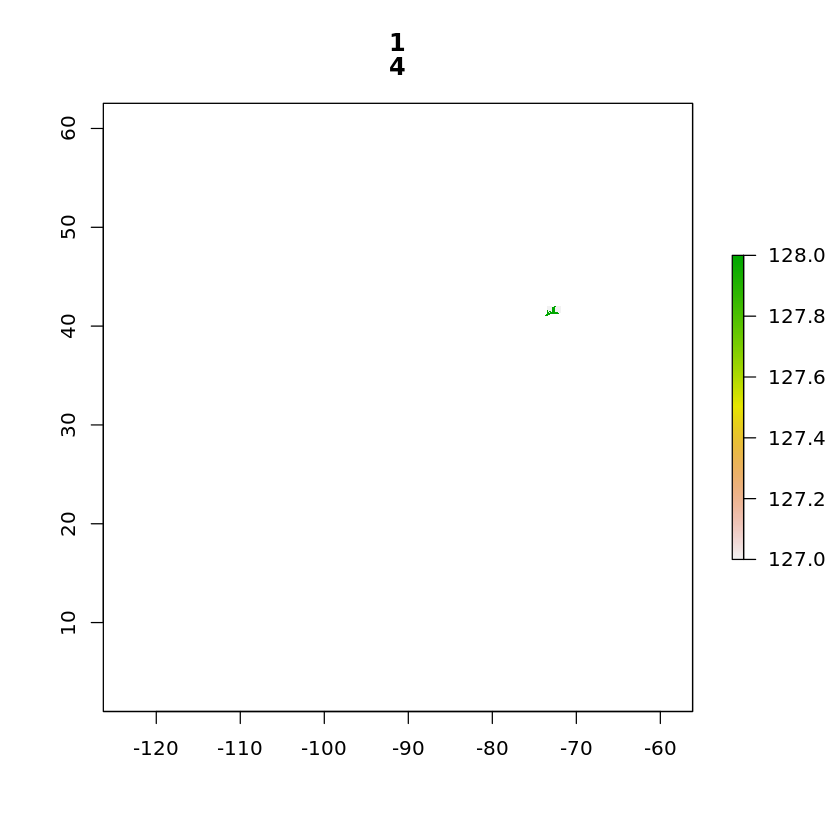

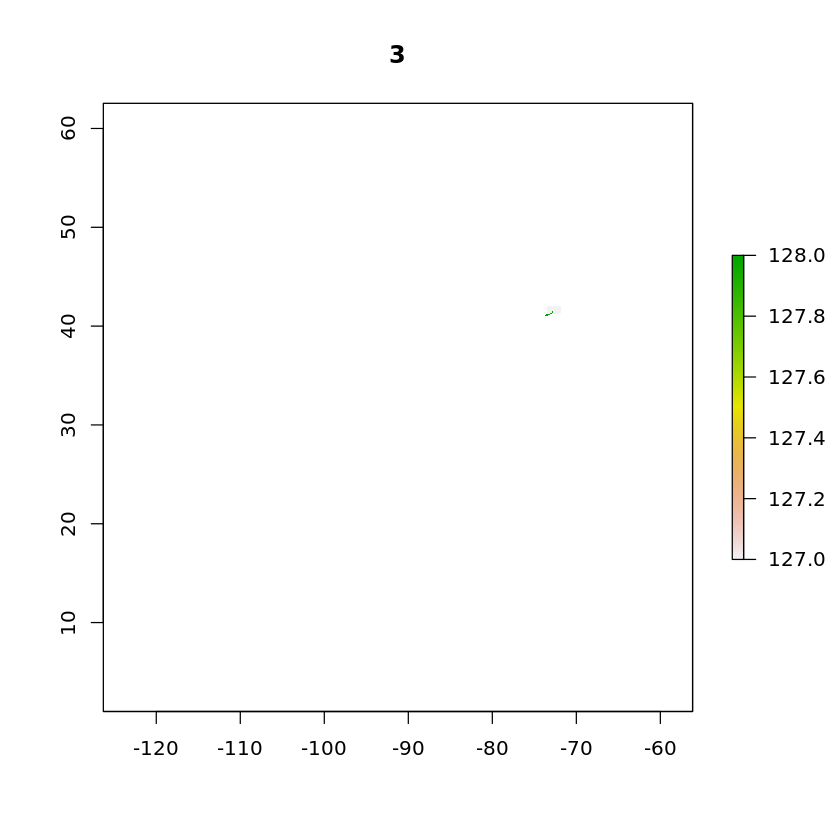

In [41]:
rasters <- vector("list", col_clus_num)
for (col_clus_ID in (1:col_clus_num)){
    years <- cFrame[cFrame$col_clus == col_clus_ID,]$year
    
    res <- rep(NA, ncell(mask))
    res[Zindex] = col_clus_matrices[,col_clus_ID]
    mat <- matrix(res, nrow(mask), ncol(mask))
    raster <- raster(mat)
    projection(raster) <- projection(mask)
    extent(raster) <- extent(mask)
    res(raster) <- res(mask)
    plot(raster, main = years)
    #readline(prompt="Press [enter] to continue once you see a plot!!!")
}